<a href="https://colab.research.google.com/github/MicheleUIT/gen-ai-photography/blob/main/image_improver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown Let's check if we are using the GPU. If not, go to **Runtime** $\rightarrow$ **Change runtime type** $\rightarrow$ **T4 GPU**
!nvidia-smi

Wed May 15 14:49:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
pip install diffusers transformers accelerate scipy safetensors accelerate

In [4]:
pip install -i https://pypi.org/simple/ bitsandbytes

Looking in indexes: https://pypi.org/simple/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

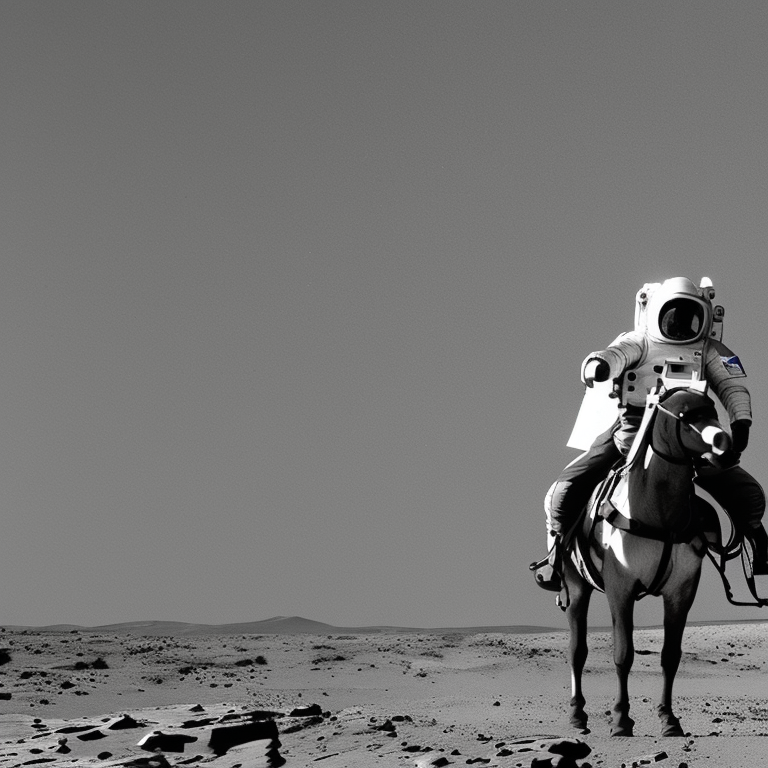

In [5]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")
image

In [7]:
import requests
from PIL import Image

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-1.5-7b-hf"

prompt = "USER: <image>\nDescribe what could be improved in this picture\nASSISTANT:"


model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

processor = AutoProcessor.from_pretrained(model_id)


raw_image = image
inputs = processor(prompt, raw_image, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))
# https://huggingface.co/llava-hf/llava-1.5-7b-hf

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/llava/configuration_llava.py:103: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ER:  
Describe what could be improved in this picture
ASSISTANT: In the image, there is a man riding a horse in a desert-like environment. The man is wearing a space suit, which is an unusual attire for a horseback rider. The scene could be improved by better coordination between the man and the horse, as well as a more cohesive and visually appealing composition. Additionally, the contrast between the man's space suit and the natural environment could be emphasized to create a more striking and memorable image.
